In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint



In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Define the base directory
base_dir = "data"  # Pas de "/" au début pour un chemin relatif
  # Replace with your actual data directory

# Define the data generator
datagen = ImageDataGenerator(rescale=1./255)

# Load all data without splitting
all_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Changer ici pour multi-classes
    shuffle=False
)


Found 10155 images belonging to 3 classes.


In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# Extract data and labels from the generator
X = []
y = []
for i in range(len(all_generator)):
    X_batch, y_batch = all_generator[i]
    X.append(X_batch)
    y.append(y_batch)
    if i >= len(all_generator) - 1:  # Avoid infinite loop
        break

X = np.vstack(X)
y = np.concatenate(y, axis=0)  # Use np.concatenate instead of np.hstack to avoid shape issues

# Split the data into training (70%) and temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation (33.33%) and test (66.67%)
# This will result in 10% validation and 20% test of the original data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6667, random_state=42)

# Now you have:
# X_train, y_train for training (70%)
# X_val, y_val for validation (10%)
# X_test, y_test for testing (20%)

# Create generators for training, validation, and test sets
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
validation_generator = datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_generator = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Verify the splits
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Training set size: 7108
Validation set size: 1015
Test set size: 2032


Found 0 images belonging to 1 classes.


Found 0 images belonging to 1 classes.


In [9]:
# Load the MobileNet model pre-trained on ImageNet, excluding the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

C:\Users\21652\AppData\Local\Temp\ipykernel_97056\511909134.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce spatial dimensions
x = Dense(1024, activation='relu')(x) 
x =  Dense(512, activation='relu')(x)   # Deuxième couche fully connected
x = Dense(256, activation='relu')(x)  # Troisième couche fully connected
x = Dense(128, activation='relu')(x)  # Quatrième couche fully connected
x = Dropout(0.5)(x)
# Modifier la dernière couche pour 3 classes
predictions = Dense(3, activation='softmax')(x)  


# Combine the base model and custom layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Modifier la fonction de perte
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',  
              metrics=['accuracy'])


In [12]:
# Train the model
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // train_generator.batch_size,  # Calculate steps manually
    validation_data=validation_generator,
    validation_steps=len(X_val) // validation_generator.batch_size,  # Calculate steps manually
    epochs=100,  # Adjust the number of epochs
    verbose=1
    callbacks=[checkpoint]  # Ajout du callback ici
)

Epoch 1/100


c:\Users\21652\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


222/222 ━━━━━━━━━━━━━━━━━━━━ 86s 368ms/step - accuracy: 0.3815 - loss: 1.0931 - val_accuracy: 0.4032 - val_loss: 1.0711
Epoch 2/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 53s 242ms/step - accuracy: 0.3438 - loss: 1.0916

c:\Users\21652\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.3438 - loss: 1.0916 - val_accuracy: 0.4446 - val_loss: 1.0719
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 98s 442ms/step - accuracy: 0.4243 - loss: 1.0725 - val_accuracy: 0.4435 - val_loss: 1.0473
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.5625 - loss: 0.9997 - val_accuracy: 0.4435 - val_loss: 1.0501
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 91s 409ms/step - accuracy: 0.4805 - loss: 1.0414 - val_accuracy: 0.5081 - val_loss: 1.0065
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.5312 - loss: 1.0126 - val_accuracy: 0.4859 - val_loss: 1.0079
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 64s 290ms/step - accuracy: 0.5183 - loss: 0.9910 - val_accuracy: 0.5474 - val_loss: 0.9709
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4375 - loss: 1.0517 - val_accuracy: 0.5524 - val_loss: 0.9668
Epoch 9/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 69s 309ms/step - accuracy: 0.5493 - loss: 0.9630 - va

In [13]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.7772 - loss: 0.5681
Test Accuracy: 0.7756


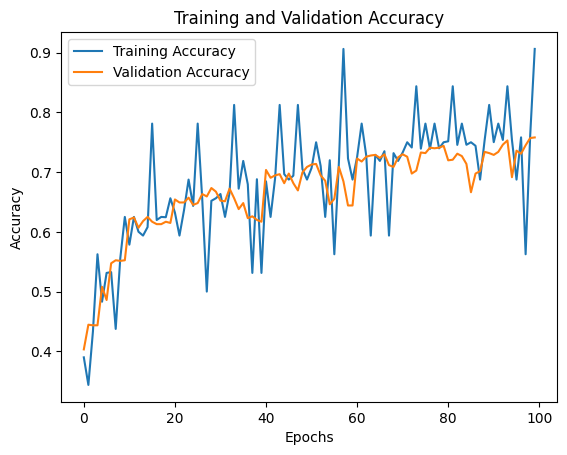

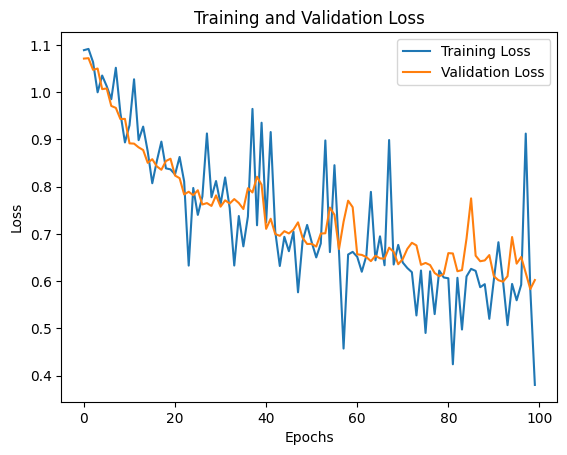

In [14]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [15]:
model.save('model2.h5')

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Charger le modèle pré-entraîné
model = tf.keras.models.load_model('model2.h5')

# Dictionnaire des émotions pour 3 catégories
emotion_labels = ['Tres Fatigue', 'Neutre', 'fatigue']

# Ouvrir la caméra
cap = cv2.VideoCapture(0)

# Vérifier si la caméra est bien ouverte
if not cap.isOpened():
    print("Erreur : impossible d'ouvrir la caméra.")
    exit()

# Chargement du classificateur de visage OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Variable pour stocker la dernière position du visage détecté
last_face = None

while True:
    ret, frame = cap.read()

    if ret:
        # Convertir en niveaux de gris pour la détection des visages
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Détecter les visages
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        # Si aucun visage n'est détecté et qu'un dernier visage existe, le réutiliser
        if len(faces) == 0 and last_face is not None:
            faces = [last_face]

        # Pour chaque visage détecté
        for (x, y, w, h) in faces:
            last_face = (x, y, w, h)  # Sauvegarder la position actuelle du visage

            # Ajouter un padding pour capturer aussi les bras
            padding = int(h * 0.7)  # Ajuste l'extension du cadrage (70% de la hauteur du visage)

            # Définir les nouvelles coordonnées avec padding
            x1, y1 = max(x - padding, 0), max(y - padding, 0)
            x2, y2 = min(x + w + padding, frame.shape[1]), min(y + h + padding, frame.shape[0])

            # Extraire et prétraiter la région d'intérêt (ROI)
            face = frame[y1:y2, x1:x2]  # Garder l'image en couleur
            face = cv2.resize(face, (150, 150))  # Adapter à la taille du modèle (150x150x3)
            face = face.astype('float32') / 255  # Normaliser
            face = np.expand_dims(face, axis=0)  # Ajouter la dimension batch

            # Vérification de la shape
            if face.shape[1:] != (150, 150, 3):
                print(f"Erreur de shape ! Attend : (150, 150, 3) | Reçu : {face.shape[1:]}")
                continue  # Passer au visage suivant en cas d'erreur

            # Prédire l'émotion
            prediction = model.predict(face)
            max_index = np.argmax(prediction[0])  # Trouver l'émotion avec la plus grande probabilité
            emotion = emotion_labels[max_index]  # Associer au label correct

            # Dessiner un rectangle autour de la zone élargie et afficher l'émotion détectée
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Positionner le texte au-dessus du rectangle
            text_x = x1
            text_y = y1 - 10 if y1 - 10 > 10 else y1 + 20  # Positionner le texte au-dessus ou en dessous du rectangle
            cv2.putText(frame, emotion, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)

        # Afficher l'image avec la prédiction
        cv2.imshow('Détection d\'émotions', frame)

    # Quitter si l'utilisateur appuie sur 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer la caméra et fermer les fenêtres
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 